**Project Analysis of Customer Data
Group 3
Agata Rapiej, Quinty Van De Ven, Katarzyna Kasperska, Karel Wiertz**

In [1]:
get_ipython().system('pip install scikit-surprise')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 7.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633994 sha256=7a309f868604fb669c050cfb68f2001943da945910c077cf47a681de83852b69
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()
sns.set_style('whitegrid')
sns.set_context('paper', font_scale = 1.6, rc = {"lines.linewidth": 2})
import matplotlib.pyplot as plt

from surprise import Dataset
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import cross_validate

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PART 1

**MovieLens Dataset**

The dataset to be used in this project concerns the MovieLens1  dataset created 
by GroupLens Research, which is a human–computer interaction research lab in 
the Department of Computer Science and Engineering at the University of Minnesota. The dataset contains 27,753,444 five-star ratings across 58,098 movies and 283,228 users. The data was collected between January 09, 1995 and September 26, 2018. The dataset was generated on September 26, 2018. Users were selected at random for inclusion. It is important to notice that all selected users had rated at least one movie. Each user is represented by an id, no other information such as demographic information was collected.

In [4]:
# We start by reading in the MovieLens dataset. Missing values are replaced by -1.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings.csv', na_values = -1)

In [5]:
# Firstly, we inspect the first ten rows of the dataset and subsequently we gather general 
# information on the dataset.
df.head(n = 10)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
5,1,1590,2.5,1256677236
6,1,1591,1.5,1256677475
7,1,2134,4.5,1256677464
8,1,2478,4.0,1256677239
9,1,2840,3.0,1256677500


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [7]:
# We notice the timestamp column is of data type int64 and represents the number of seconds passed since 
# midnight of January 1, 1970 (UTC) which might sound vague. To make this more intuitive, timestamp needs to
# be transformed.
df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 's')

In [8]:
# If we inspect the first ten rows of the data set after timestamp is transformed, we clearly see the 
# change of timestamp. If we, afterwards, gather information on the data set again as well, we observe the data 
# type of timestamp has changed. The transformation made it data type change from int64 into datetime64.
df.head(n = 10)

,userId,movieId,rating,timestamp
0,1,307,3.5,2009-10-27 21:00:21
1,1,481,3.5,2009-10-27 21:04:16
2,1,1091,1.5,2009-10-27 21:04:31
3,1,1257,4.5,2009-10-27 21:04:20
4,1,1449,4.5,2009-10-27 21:01:04
5,1,1590,2.5,2009-10-27 21:00:36
6,1,1591,1.5,2009-10-27 21:04:35
7,1,2134,4.5,2009-10-27 21:04:24
8,1,2478,4.0,2009-10-27 21:00:39
9,1,2840,3.0,2009-10-27 21:05:00


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 847.0 MB


In [10]:
# Now our data is all in an appropriate data type, we investigate the missing values in the data set and 
# the amount of unique users and movies.
percent_missing = df.isnull().sum() * 100 / len(df)
print('Percentage of missing values: ' + str(round(percent_missing['rating'], 2)) + '%')

unique_users = len(df['userId'].unique())
print('Number of unique users: ' + str(unique_users))

unique_movies = len(df['movieId'].unique())
print('Number of unique movies: ' + str(unique_movies))

Percentage of missing values: 0.0%
Number of unique users: 283228
Number of unique movies: 53889


In [11]:
# A missing value score of 0.0% implies the used dataset does not contain any missing value (NaN).
# However, datasets used in practice as input for recommender system usually contain some missing values,
# especially regarding ratings given by users. We might want to verify this dataset does indeed not contain
# any missing value. We will do this by dropping all missing values in the dataset and observe whether this
# changes either one of the percentage of missing values, the number of unique users or the number of unique movies.
df.dropna(axis = 'index', inplace = True)

percent_missing = df.isnull().sum() * 100 / len(df)
print('Percentage of missing values: ' + str(round(percent_missing['rating'], 2)) + '%')

unique_users = len(df['userId'].unique())
print('Number of unique users: ' + str(unique_users))

unique_movies = len(df['movieId'].unique())
print('Number of unique movies: ' + str(unique_movies))

Percentage of missing values: 0.0%
Number of unique users: 283228
Number of unique movies: 53889


In [12]:
# The missing values score turns out to be 0.0% again and the numbers of unique users and movies do not change,
# even after dropping possible NaN-values. Hence, we can indeed conclude this dataset does not contain any
# missing value.
# Next, we want to get insight into given ratings. A first insight is obtained by the descriptive statistics on ratings
# and how many times each rating (between 0.5 and 5.0) is given. 
df['rating'].describe()

count    2.775344e+07
mean     3.530445e+00
std      1.066353e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [13]:
# Descriptive statistics on rating show its the average rating per movie is approximately 3.5 stars with
# a standard deviation of approximately 1 star. Other descriptive statistics are affected by the
# limited number of values (as ratings can only be values between 0.5 and 5.0 with intervals of 0.5).
# Therefore, it is more interesting to look at the number of times each rating was given.
df['rating'].value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

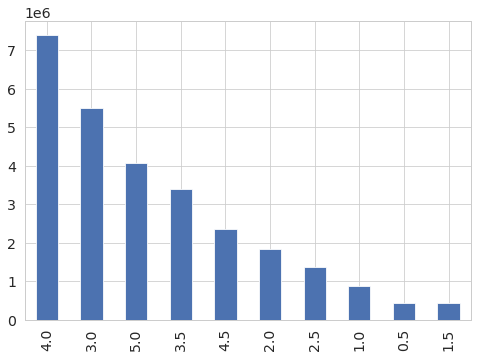

In [14]:
# As solely numbers might be difficult to interpret, we construct a bar plot and a pie chart based on 
# value counts of all ratings.
df['rating'].value_counts().plot(kind = 'bar', figsize = (8, 5.5))

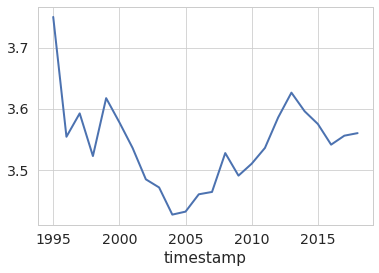

In [16]:
# The rating of four stars is given most often, followed by three stars and five stars. Low ratings are given
# less often. This might make the data more skewed towards higher ratings.
# While the three most-given ratings consist of three .0-ratings, the three least-given 
# ratings consist of two .5-ratings and just one .0-rating. This might indicate that people are less likely
# to give 'half-star' ratings compared to 'full-star' ratings.
# As last investigation of the ratings, we observe the development of yearly average ratings over time by
# a line plot.
df.groupby(df['timestamp'].dt.year)['rating'].mean().plot(kind = 'line')

In [17]:
# We notice average ratings have their peak in the year 1995, after which it starts to drop. The lowest
# average rating per movie is found in the year 2004. After this, the average rating increases again.
# After a short peak around the year 2013, the average rating ends at its current level of approximately 3.5
# stars in 2018.
# Our next point of interest is the movie which received the most ratings. This is done by observing the
# number of times a movieId was registered in a rating (i.e. looking at a movieId's value counts).
df['movieId'].value_counts()

318       97999
356       97040
296       92406
593       87899
2571      84545
          ...  
165077        1
172453        1
192975        1
167092        1
142855        1
Name: movieId, Length: 53889, dtype: int64

In [18]:
# Movie with movieId 318 (from now on referred to as movie 318) turns out to be the movie to receive the most
# ratings as it was rated 97,999 times. The values at the bottom indicate several movies exist which only got rated once.
# We now further focus on the most often rated movie. We first observe its descriptive statistics.
df.groupby('movieId')['rating'].get_group(318).describe()

count    97999.000000
mean         4.424188
std          0.763178
min          0.500000
25%          4.000000
50%          4.500000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

In [19]:
# The most informative statistic is the average rating of movie 318 which is with approximately 4.5 stars
# relatively high. This is indicated as well by the quartiles as these show high values (4 stars and higher)
# as well. We further investigate the number of times movie 318 received each rating.
df.groupby('movieId')['rating'].get_group(318).value_counts()

5.0    48762
4.0    22216
4.5    14110
3.0     5668
3.5     4384
2.0      950
2.5      875
1.0      441
0.5      369
1.5      224
Name: rating, dtype: int64

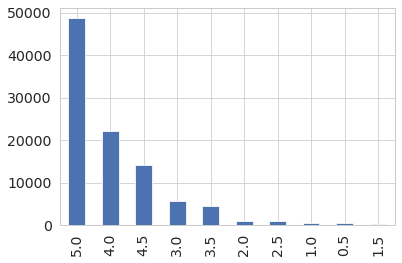

In [20]:
# These numbers show the most rated movie received the highest rating most often. The rating it received most
# often (5 stars) was given more than twice as much times as the value it received second most often (4 stars).
# As the numbers above show some interesting aspects, analysing the given ratings is more intuitive to do 
# by a bar plot.
df.groupby('movieId')['rating'].get_group(318).value_counts().plot(kind = 'bar')

In [21]:
# This barplot clearly shows the movie 318 received high ratings (4 stars and more) far more often than 
# low ratings (2.5 stars and less). Hence, this indicates a great probability this movie will score high
# in the ranking of highest ranked movies. Especially the number of times the movie is rated with 5 stars
# is prominent, so we further explore this by inspecting the 10 movies which received the 5 stars rating
# most often.
data2 = df.query('rating == 5')
print(data2['movieId'].value_counts().head(10))

318     48762
296     37458
356     32009
260     31385
593     30280
527     30194
2571    30126
858     28893
50      24679
2959    24366
Name: movieId, dtype: int64


In [22]:
# This ranking shows the movie 318 indeed received most often the highest possible ranking. However, 
# movie 318 is not the only movie to receive the 5 stars rating often. Movie 318, movie 296 and movie 356
# together form the top 3 of movies to receive the 5 stars rating most often. We further inspect these movies.
top3 = df[df['movieId'].isin([318, 296, 356])]
print(top3)

          userId  movieId  rating           timestamp
107            4      296     5.0 2005-04-17 19:44:16
111            4      318     5.0 2005-04-17 19:35:05
122            4      356     3.5 2005-04-17 19:44:19
781            5      296     5.0 2008-04-24 12:26:50
782            5      318     5.0 2008-04-24 12:28:24
...          ...      ...     ...                 ...
27752884  283222      296     4.5 2004-04-20 03:43:07
27752987  283224      296     5.0 1996-12-19 12:17:47
27752992  283224      318     4.0 1996-12-19 12:15:27
27753002  283224      356     4.0 1996-12-19 12:16:01
27753337  283228      356     4.0 2013-09-22 20:46:16

[287445 rows x 4 columns]


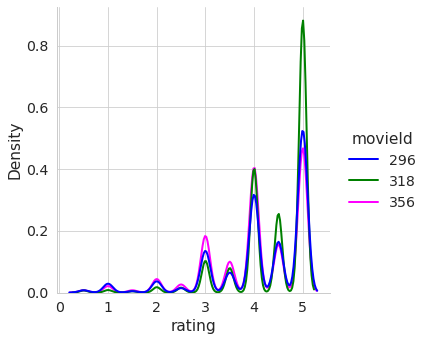

In [23]:
# This table lacks intuition, so it is hard to subtract insights from this. Therefore we construct a kernel 
# density estimation plot based on this data.
sns.displot(top3, x = 'rating', hue = 'movieId', kind = 'kde', palette = ['blue', 'green', 'magenta'])

In [24]:
# This plot is clearly more interpretable than the previous table. It becomes visual that all three movies
# receive the 5 stars rating most often, while the second most often given rating for all three movies is
# the 4 stars rating and not the 4.5 stars rating. This can be due the to earlier noticed phenomenom that
# users are more likely to give .0-ratings than .5-ratings. Another conclusion we can draw based on this plot 
# is that movies receiving the 5 stars rating often are likely to receive other high ratings often too.
# Besides inspecting movies receiving the highest rating most often, it is interesting as well to look at
# movies receiving the lowest rating most frequent.
data3 = df.query("rating == 0.5")
print(data3["movieId"].value_counts().head(10))

19       1132
231      1119
2710     1095
3593     1088
2628     1010
260      1002
63992     991
1562      973
4993      946
7153      932
Name: movieId, dtype: int64


In [25]:
# This ranking indicates movie 19 received the lowest raking of 0.5 stars with 1,132 times most often.
# Movie 231 is the second movie to receive this rating most often, followed by movie 2710. We further 
# inspect these movies.
bottom3 = df[df['movieId'].isin([19, 231, 2710])]
print(bottom3)

          userId  movieId  rating           timestamp
49             4       19     2.0 2005-04-17 19:48:44
98             4      231     0.5 2005-04-17 19:45:53
398            4     2710     0.5 2005-08-14 03:33:47
1468          16      231     3.0 1996-04-15 09:02:46
1499          18       19     2.0 1996-10-11 19:17:56
...          ...      ...     ...                 ...
27752689  283217       19     1.0 1996-05-05 07:10:57
27752879  283222       19     2.0 2004-04-20 03:53:09
27752957  283224       19     1.0 1996-12-19 12:25:27
27753304  283226      231     2.0 2001-09-27 19:45:21
27753312  283226     2710     2.0 2001-09-27 19:45:53

[85511 rows x 4 columns]


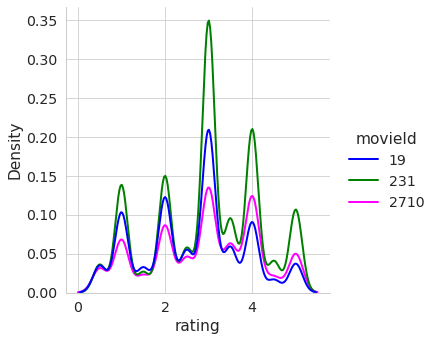

In [26]:
# Just like before, this table is hardly interpretable. Hence, we construct a kernel density estimation plot again.
sns.displot(bottom3, x = 'rating', hue = 'movieId', kind = 'kde', palette = ['blue', 'green', 'magenta'])

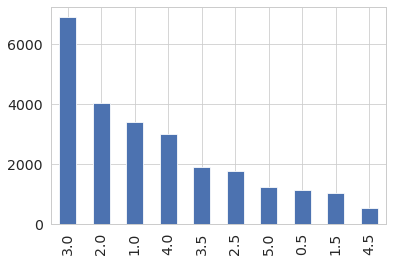

In [27]:
# This plot indicates interesting things. For all three movies, the lines peak at .0-ratings and drop 
# at .5-ratings, which again indicates users are more likely to give full stars ratings compared to half 
# stars ratings. On the other hand, despite movie 19, movie 231 and movie 2710 form the top three of movies
# receiving the 0.5 stars rating most often, these movies receive other ratings (2 stars, 3 stars and 4 stars)
# approximately equally often or even more often. Hence, receiving the lowest rating most often does not
# directly imply a movie only receives bad ratings. We further elaborate on this by focusing on movie 19.
df.groupby('movieId')['rating'].get_group(19).value_counts().plot(kind = 'bar')

In [28]:
# This barplot clearly shows movie 19 gets ratings other than the 0.5 stars rating more often than it gets 
# the 0.5 stars ratings. Hence, concluding that movie 19 is a bad movie solely because it gets the 0.5 stars 
# rating most often is incorrect. We further inspect this by looking at the average rating of movie 19.
df.groupby('movieId')['rating'].get_group(19).mean()

2.6420142094488823

In [29]:
# With an average rating of approximately 2.5 stars, movie 19 might not be labelled as a good movie,
# but it is far better than what might be thought at first when it was shown movie 19 received - out of 
# all movies - the lowest rating most often. Labelling movie 19 as a mediocre movie is most correct.
# Besides looking at most often rated movies or most often given rating, inspecting the user who gave
# the most ratings is interesting as well.
df['userId'].value_counts()

123100    23715
117490     9279
134596     8381
212343     7884
242683     7515
          ...  
188125        1
117282        1
127062        1
241836        1
265726        1
Name: userId, Length: 283228, dtype: int64

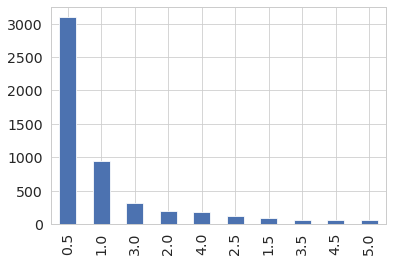

In [30]:
# Hence, by looking at the number given ratings by each user, we conclude the user with userId 94843 
# (from now on referred to as user 94843) gave the most ratings. We further examine the ratings given by 
# user 94843 by constructing a barplot on this.
df.groupby('userId')['rating'].get_group(94843).value_counts().plot(kind = 'bar')

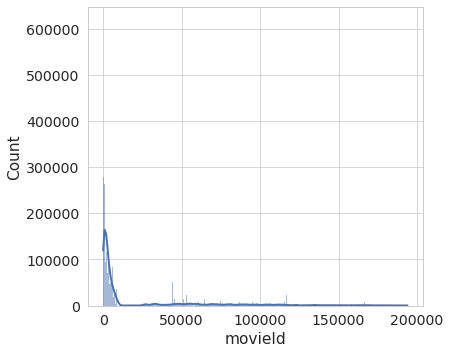

In [31]:
# This barplot clearly shows user 94843 tends to negatively rate movies. Ratings of 0.5 stars are obviously
# given the most often. The amount of given 0.5 stars ratings is even more than the number of all other 
# given ratings aggregated.
# The next interesting aspect we examine is the relationship between movieId and the number of received ratings. 
# As seen before, some movies (e.g. movie with movieId 318) received numerous ratings, while other movies 
# received just one rating. This relationship will be shown by a density plot.
def plot_density(df):
    
    fig, ax = plt.subplots(figsize = (6,5.5))
    plot = sns.histplot(df['movieId'], kde = True, ax = ax)

plot_density(df)

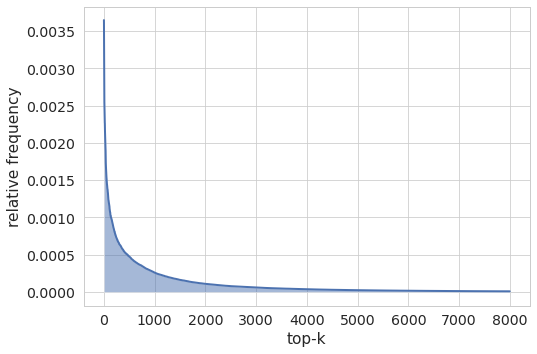

In [32]:
# From this density plot we can observe that movies with a high movieId tend to receive significantly less
# ratings than movies with a low movieId. Hence, probability density values differ quite heavily. Therefore, 
# we will base our recommender system on solely the top-k movies. Which k we will pick, is decided by analysing 
# a plot with the relative frequency of the top 8,000 items. 8,000 is picked as a cut-off point from the previous
# plot.
def plot_frequency(df, k):
    
    fig, ax = plt.subplots(figsize = (8,5.5))
    counts = df['movieId'].value_counts(sort = True, ascending = False)
    orig = counts.index.tolist()
    counts2 = counts.reset_index(inplace = False, drop = True)
    sub = counts2.index.tolist()

    sns.lineplot(x = counts2.index[0: k], y = counts2[0: k] / counts2[0: k].sum(), ax = ax)
    ax.fill_between(counts2.index[0: k], counts2[0: k] / counts2[0: k].sum(), alpha = 0.5)
    ax.set_ylabel('relative frequency')
    ax.set_xlabel('top-k')

plot_frequency(df, k = 8000)

In [33]:
# This plot shows the relative function of the top 8,000 movies in the dataset. It seems reasonable to
# only evaluate the top 4,000 movies since this is a very large dataset and we want to save computational
# resources. k is set at 4,000 because this is the smallest integer whose relative frequency almost equalling zero. 
# In line with this decision, we create a new dataset which only contains the top 4,000 movies.
def select(df, k, col):

    top_values = df[col].value_counts().nlargest(k)
    return df.loc[df[col].isin(top_values.index)]

df = select(df, k = 4000, col = 'movieId')

In [34]:
# As we changed our dataset by only keeping the top 4,000 movies, the number of unique users and movies 
# is affected. The percentage of missing values will remain 0.0%, so this will not be recalculated.
unique_users = len(df['userId'].unique())
print('Number of unique users: ' + str(unique_users))

unique_movies = len(df['movieId'].unique())
print('Number of unique movies: ' + str(unique_movies))

Number of unique users: 282727
Number of unique movies: 4000


In [35]:
# After selecting the top 4,000 movies, 282,727 unique users (out of 283,228) and 4,000 unique movies 
# (out of 53,889) were left in the dataset. We inspect this new dataset by looking at its descriptive statistics.
df['rating'].describe()

count    2.497150e+07
mean     3.564248e+00
std      1.055298e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

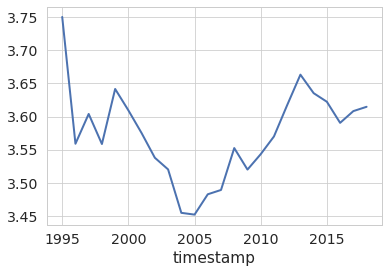

In [36]:
# Comparing these descriptive statistics leads to the conclusion that only focusing on the top 4,000 movies 
# positively impacts the statistics on ratings. The mean increases while the standard deviation decreases
# and the 2nd quartile (i.e. the median) shifts from 3.5 stars to 4 stars.
# The last thing we inspect is the development of average ratings over the years of the top 4,000 movies.
df.groupby(df['timestamp'].dt.year)['rating'].mean().plot(kind = 'line')

In [37]:
# Comparing this plot to the plot based on all movies in the dataset yields the conclusion there are no
# noteworthy differences between the development of average ratings over time.

# PART 2

In [38]:
# During running the code for second part of the project (building algorithms), we have encountered a great
# issue with the size of the dataset. Running the code for the whole dataset resulted each time in crashing the
# program due to insufficient memory. As a result, we have tried to use a sample of the data.
# Unfortunately, using 25%, 1% or even 0.1% did not help and we still encountered a RAM problem, using both
# Jupyter notebook as well as Google Colab. After many trials we have found that the algorithms work when
# we are using around 15,000 rows of the dataset. Therefore, we have created a subset of the dataset that contains
# around 15,000 rows. In order to create a representative sample, we have checked what percentage of the dataset
# each movie takes so that we could create a subset which also follows that distribution. Based on that we have
# calculated how many instances each movieId will get in the subset.  

#number of rows of the dataset
rows = len(df)

#frequency of each movie
freq = pd.crosstab(index=df['movieId'], columns='count')

#list with frequencies
count = freq['count'].values.tolist()

#list with movieIds
movie = freq.index.tolist()

#probability of each movieId
probability = [x / rows for x in count]

#amount of times each movie will be presented when using 15k rows
import math
subset = [math.ceil(x * 15000) for x in probability]

#creating subset containing movieId and number of records it will occupy in the subset
movies_distr = pd.DataFrame(
    {'movieId':movie,
     'n_rows': subset})
print(movies_distr)

      movieId  n_rows
0           1      42
1           2      17
2           3      10
3           4       2
4           5      10
...       ...     ...
3995   177765       2
3996   179401       1
3997   179819       2
3998   180031       1
3999   187593       1

[4000 rows x 2 columns]


In [39]:
# After obtaining the dataframe with movieIds and frequencies, we have created an actual subset
# which follows the distribution of the dataset where k=4000 (so already the subset that we wanted to work on, 
# but which was too big to run the algorithms on). The code used below was sourced from a website
# https://stackoverflow.com/questions/33097167/sampling-a-dataframe-based-on-a-given-distribution and adapted
# to our needs.

def bootstrap(data, freq):
    freq = freq.set_index('movieId')

    def sampleClass(classgroup):
        cls = classgroup['movieId'].iloc[0]
        nDesired = freq.n_rows[cls]
        nRows = len(classgroup)

        nSamples = min(nRows, nDesired)
        return classgroup.sample(nSamples)

    samples = data.groupby('movieId').apply(sampleClass)

    samples.index = samples.index.get_level_values(1)

    return samples

df_sample = bootstrap(df,movies_distr)
print(df_sample)
df_sample.info()

          userId  movieId  rating           timestamp
15618266  159458        1     3.0 2008-10-24 09:20:45
17188643  175611        1     3.0 2000-11-19 04:02:47
12870791  131757        1     3.0 2008-03-29 21:29:33
25631900  261852        1     3.5 2009-09-27 00:48:51
8355291    86008        1     4.0 2005-04-01 16:21:35
...          ...      ...     ...                 ...
18982877  193681   179401     5.0 2018-06-15 23:10:32
15464949  157983   179819     4.0 2017-12-29 21:03:21
11944844  122608   179819     5.0 2018-06-05 17:11:07
16618391  170008   180031     4.5 2018-07-22 02:32:08
3948752    40692   187593     4.0 2018-07-14 16:29:25

[16851 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16851 entries, 15618266 to 3948752
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   userId     16851 non-null  int64         
 1   movieId    16851 non-null  int64         
 2   rating     16851

In [40]:
# Analyzing descriptive statistic shows that the values don't differ 
# significantly from the values of the original dataset. 
df_sample['rating'].describe()

count    16851.000000
mean         3.551777
std          1.067112
min          0.500000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [41]:
df = df_sample

In [42]:
# A reader is still needed but only the rating_scale param is required.
# We set the rating_scale param to 0.5-5 since users can rate movies from 0.5 star to 5 stars
reader = Reader(rating_scale=(0.5, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

**Baseline model**

In [43]:
cross_validate(NormalPredictor(), data, cv=5, return_train_measures=True)

{'test_rmse': array([1.44774466, 1.44319323, 1.46235144, 1.47045311, 1.48217328]),
 'train_rmse': array([1.45421798, 1.45040305, 1.4480146 , 1.46671274, 1.45103343]),
 'test_mae': array([1.15851759, 1.14412097, 1.16470794, 1.17586253, 1.18666606]),
 'train_mae': array([1.15880524, 1.15356109, 1.15559413, 1.16723363, 1.15627838]),
 'fit_time': (0.01422572135925293,
  0.013419866561889648,
  0.01762247085571289,
  0.017505645751953125,
  0.016684293746948242),
 'test_time': (0.023563146591186523,
  0.024448633193969727,
  0.025550127029418945,
  0.023365259170532227,
  0.022161483764648438)}

**Neighborhood method**

The first method that has been chosen is the k Nearest Neighbors inspired k-NN with z-score. K-NN algorithms choose the label of the unclassified data based on the label that the majority of the k-nearest neighbors have. K-NN with z-score uses z-score normalization of each user.

Normalization is used in order to remove outliers. It subtracts population mean from all of the points in the dataset and divides that value by population standard deviation.
The algorithm consists of a few hyperparameters that can be tuned:



*   The maximal number of neighbors (k) that are taken into account. It describes the maximal number of neighbors that are considered when deciding on the class of unlabeled data. The default is set to 40.
*   The minimum number of neighbors (min_k) that are taken into account. It describes the minimum number of neighbors that are considered when deciding on the class of unlabeled data. The default is set to 1.
*   The similarity metrics (sim_options) that are used to compute the similarity between all pairs of users or items. In k-nn they are used to determine the distance between the neighbors. There are four available metrics: 
    * Cosine similarity is the cosine of the angle between two vectors and is used as a distence between two points on the vectors. As the value increases, the similarity decreases. 
    * Mean Squared Difference similarity is based on the geometrical principles of the Euclidean distance .
    * Pearson correlation coefficient can be described as a mean-centered cosine similarity. 
    * Shrunk Pearson correliation coefficient with baselines used for centering instead of means. The shrinkage parameter helps to avoid overfitting when only few ratings are available.
* Another setting under the similarity measure configuration is the "user_based" setting. This variable takes a boolean value and when set to True it will compute similarities between users and when set to False it will compute similarity between items.
*  Verbose which defines if the program should print trace messages of bias estimation, similarity, etc.



In [44]:
from surprise import KNNWithZScore
from surprise.model_selection import GridSearchCV

**Hyper-parameters**


We use grid search to find which hyperparameter values are best to use. The grid search tries every possible combination of the hyperparameters and returns the best combination in the end. When tuning the hyperparameters for the KNNwithZscore method with the grid search we used the following parameters: k, min_k, user-based and the distance function.

The default setting for maximal number of neighbours (k), minimum number of neighbours (min_k), (user_based) and the name of the similarity metric are 40, 1, True and MSD. However, that might be not the optimal setting
for our data, we will make two configurations when doing hyperparameter tuning. As the possible options for similarity metrics are cosine, Mean Square Difference, Pearson and baseline Pearson, we will divide them between two configurations such that each configuration is going to choose metrics from two options (cosine vs msd and pearson vs baseline pearson). Values for maximal and minimal number of neighbours have been chosen randomly. The first configuration uses the following values: for the maximal number of neighbours 10, 20 and 30, for the minimum number of neighbours 1, 2, 3, 4 and 5, for user_based True and False, and for the similarity metric we'll be looking at cosine and Mean Square Difference (msd). 

In [45]:
# First we write down the parameters we want the grid search to consider.
param_grid = {"k": [10,20,30], 
              "min_k": [1,2,3,4,5], 
              "user_based": [True, False],
             " name": ["cosine", "msd"],
             } 

In [46]:
# We implement the grid search with the parameters stated above
gs_knn = GridSearchCV(KNNWithZScore, param_grid, measures=["rmse"], cv=5)

# We fit the grid search to our data
gs_knn.fit(data)

# Return the best RMSE score
print(gs_knn.best_score["rmse"])

# Return the combination of parameters that gave the best RMSE score
print(gs_knn.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

The grid search has found the following settings to be the most optimal for our dataset: {'k': 10, 'min_k' : 1, 'user_based' : True, 'name' : 'cosine'}. We will now use these settings and cross-validate them with our data. 

In [47]:
knn_1 = KNNWithZScore(k=10, min_k=1, user_based = True, name="cosine")
cross_validate(knn_1, data, cv=5, return_train_measures=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([1.10891402, 1.12781068, 1.13103156, 1.09840387, 1.11556607]),
 'train_rmse': array([0.21287395, 0.20790706, 0.20966719, 0.20918874, 0.20737514]),
 'test_mae': array([0.86279205, 0.8896214 , 0.89552543, 0.86823002, 0.87764965]),
 'train_mae': array([0.10358375, 0.09888424, 0.10295958, 0.10139776, 0.09948448]),
 'fit_time': (3.9402079582214355,
  5.114866018295288,
  3.7692160606384277,
  5.129620552062988,
  4.066056251525879),
 'test_time': (0.028459787368774414,
  0.030193090438842773,
  0.03344988822937012,
  0.029355287551879883,
  0.028880834579467773)}

The following are the results of 5 cross validation on the first configuration. The test RSME are 1.10891402, 1.12781068, 1.13103156, 1.09840387, 1.11556607 and for train RSME 0.21287395, 0.20790706, 0.20966719, 0.20918874, 0.20737514. 

The second configuration takes into account 15, 25 and 35 for values of k, 1, 2, 3, 4 and 5 for min_k and similarity measures Pearson and baseline Pearson.

In [48]:
param_grid_2 = {"k": [15,25,35], 
              "min_k": [1,2,3,4,5], 
              "user_based": [True, False],
             " name": ["pearson", "baseline_pearson"],
             } 

In [49]:
gs_knn_2 = GridSearchCV(KNNWithZScore, param_grid_2, measures=["rmse"], cv=5)

gs_knn_2.fit(data)

# best RMSE score
print(gs_knn_2.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs_knn_2.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

The grid search has found the following settings to be the most optimal for our dataset: {'k': 15, 'min_k' : 1, 'user_based' : True, 'name' : 'pearson'}. We will now use these settings and cross-validate them with our data. 

In [50]:
knn_2 = KNNWithZScore(k=15, min_k=1, user_based = True, name="pearson")
cross_validate(knn_2, data, cv=5, return_train_measures=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([1.10785153, 1.11155172, 1.10058051, 1.12085022, 1.12143586]),
 'train_rmse': array([0.20810233, 0.20985971, 0.21119862, 0.21263679, 0.210635  ]),
 'test_mae': array([0.87351203, 0.87118869, 0.86802399, 0.88128288, 0.88612357]),
 'train_mae': array([0.10004737, 0.10229699, 0.10069877, 0.10262212, 0.10242621]),
 'fit_time': (5.170235633850098,
  5.571821212768555,
  6.44625997543335,
  5.9513936042785645,
  5.2227418422698975),
 'test_time': (0.031873464584350586,
  0.028362751007080078,
  0.029851436614990234,
  0.028855323791503906,
  0.031409263610839844)}

The following are the results of 5 cross validation on the second configuration. The test RSME are 1.10785153, 1.11155172, 1.10058051, 1.12085022, 1.12143586 and for train RSME 0.20810233, 0.20985971, 0.21119862, 0.21263679, 0.210635. 

**Discussion**

The KNN with z-score model seems to be performing a bit better than the baseline model. The RSME values the KNN model returns for the training set are way lower than the values the baseline model returns (0.2 vs 1.4 respectively). Besides that, the RMSE for both KNN models regardigng the test set are lower than the one for baseline (1.1 vs 1.4 respectively). There does not seem to be that big of a difference between the two configurations of the KNN model. Both return around the same values for the training and test RMSE. It should be noted, however, that the KNN model is clearly overfitting to the training data. This can be seen when comparing the RMSE values of the training set and the test set. While the RMSE values of the training set usually stay around 0.2, that of the test set skyrockets back up to around 1.1. Therefore, it can be said that this model does not perform well on unseen data. This can partially be explained by the size of the dataset used. Since we were running into RAM usage issues while running the models, we only used a very small subset of the data. Therefore, the model did not have many instances to learn from and easily overfits to the cases it does know. In future studies, a bigger chuck of the dataset should be used in order to make better predictions with the models. Besides that, it could be useful to try different hyperparameter values. It might turn out that other k values may produce better results.

**Matrix factorization-based method**

The Singular Value Decomposition (SVD) algorithm is derived from linear algebra and has primarily been used in machine learning as a dimensionality
reduction technique. SVD is a matrix factorization technique that reduces the number of features in a dataset by reducing the space dimension from N to K, 
resulting in K being less than N. In recommender systems, SVD is used as a collaborative filtering technique. The matrix structure is made up
of rows that represent users and columns that represent items. The ratings that the user has given are treated as matrix elements (Kumar, 2020).

The SVD model was chosen for matrix factorization in this project due to its high accuracy in previous studies and its widespread use in Netflix
prize competitions, including one presented by Simon Funk in his famous Try This at Home blogpost. Another prediction algorithm, SVD ++, has been
considered. Although SVD++ outperforms SVD in several studies, it is not always preferable to use SVD++. When compared to the naive SVD, SVD++ takes
significantly longer to train. Given the size of our database, it may take too long to run it and evaluate the results.

When tuning the hyperparameters for SVD with the grid search we used the following parameters: learning rate, regularization term and number of epochs.
A factor known as learning rate determines the ratio of the old and new computed values after each iteration. In practice, when using high values, 
the optimal solution may be skipped, whereas when using low values, many iterations are required to reach the optimal value. We add a penalty term to
our minimization equation so that our model can generalize well while not over-fitting the training set. A regularization term represents this. 
The number of epochs counts how many parameter updates that model is carrying out.

In [51]:
from surprise import SVD

The default setting for learning rate, regularization term and number of epochs are 0.005, 0.02 and 20. However, that might be not the optimal setting
for our data, we will make two configurations when doing hyperparameter tuning. The first configuration focuses on a smaller grid. The included values
 for the learning rate are 0.001 and 0.002, for the regularization term 0.02 and 0.08 and for the number of epochs 10,20 and 30. In the first configuration we want to see if the smaller parameter will conclude in smaller RSME. If not, we will increase our parameters in the second configuration to see if using larger parameters has a positive or a negative effect on RSME.

The most popular methods to evaluate the recommender systems is Root Square Mean Error (RSME) and Mean Absolute Error( MAE). 
Both are widely used due to easy interpretation. The RMSE is similar to the MAE, but the absolute value of the residual is squared, 
and the square root of the entire term is used for comparison. The benefit of using RMSE instead of MAE is that it penalizes the term 
more when the error is large. As previously stated, the RSME will be used to evaluate the recommendation's quality. According to a rule of thumb,
RMSE values between 0.2 and 0.5 indicate that the model can reasonably predict the data.  

In [52]:
from surprise.model_selection import GridSearchCV

# Use movielens data

param_grid = {"n_epochs": [5,10],
    "lr_all": [0.001, 0.002],
    "reg_all": [0.02, 0.08]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=5)

gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

1.0474611871991661
{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.02}


The Grid Search found the best set of parameters: 10 epochs, 0.002 learning rate, and 0.02 regularisation term. These settings will be used as the first configuration on five fold cross validation.

In [56]:
SVD1 = SVD(n_epochs=10 , lr_all=0.002, reg_all= 0.02)

In [57]:
# Run 5-fold cross-validation and print results.
cross_validate(SVD1, data, cv=5, return_train_measures=True)

{'test_rmse': array([1.03580571, 1.06397391, 1.0491104 , 1.02021019, 1.06828148]),
 'train_rmse': array([0.97368046, 0.96760117, 0.97076799, 0.97698595, 0.96652782]),
 'test_mae': array([0.83001245, 0.84017799, 0.82662358, 0.80839433, 0.84643563]),
 'train_mae': array([0.77011192, 0.7662084 , 0.76995902, 0.77597834, 0.76564943]),
 'fit_time': (0.4212191104888916,
  0.42732882499694824,
  0.439424991607666,
  0.41717100143432617,
  0.4244229793548584),
 'test_time': (0.0224151611328125,
  0.017523527145385742,
  0.019980669021606445,
  0.017967939376831055,
  0.028072357177734375)}

We test the ability of a machine learning model to predict new data. Cross validate function is also used to flag problems like overfitting or selection bias and gives insights on how the model will generalize to an independent dataset. The following are the results of 5 cross validation on the first configuration. The test RSME are 1.03580571, 1.06397391, 1.0491104 , 1.02021019, 1.06828148 and for train RSME 0.97368046, 0.96760117, 0.97076799, 0.97698595, 0.96652782. 

In the second configuration, for each hyperparameter we include two other values next to the default setting, one value being lower 
than the default setting and the other value being higher than the default setting. Hence, for the learning rate we include 0.002, 0.005 and 0.01,
for the regularization term 0.01, 0.02 and 0.1 and for the number of epochs we include the values 10, 20 and 30.

In [55]:
param_grid2 = {"n_epochs": [10, 20, 30],
    "lr_all": [ 0.002, 0.005, 0.01],
    "reg_all": [0.01, 0.02, 0.1]}
gs = GridSearchCV(SVD, param_grid2, measures=["rmse"], cv=5)

gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

1.0234243709606707
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}


After running the Grid Search second time with difrent hyperparameter values, we found the best set of parameters for the second configuration: 20 epochs, 0.01 learning rate, and 0.1 regularisation term. These settings will be used to run cross validation on 5 folds.

In [58]:
SVD2 = SVD(n_epochs=20 , lr_all=0.01, reg_all= 0.1)

In [59]:
# # Run 5-fold cross-validation and print results.
cross_validate(SVD2, data, cv=5, return_train_measures=True)

{'test_rmse': array([0.99659785, 1.01866507, 1.03289069, 1.04832872, 1.03121691]),
 'train_rmse': array([0.51349423, 0.50847052, 0.50689682, 0.5068236 , 0.50830073]),
 'test_mae': array([0.77941932, 0.79331489, 0.8089227 , 0.81414944, 0.80837823]),
 'train_mae': array([0.40319262, 0.40106889, 0.39816899, 0.39790906, 0.39920883]),
 'fit_time': (0.7497818470001221,
  0.7901501655578613,
  0.7571024894714355,
  0.7475845813751221,
  0.766998291015625),
 'test_time': (0.017901897430419922,
  0.020051002502441406,
  0.02344822883605957,
  0.016791582107543945,
  0.026447296142578125)}

And here are the following results of the second configuration: Test RSME for 5 cross validation is 0.99659785, 1.01866507, 1.03289069, 1.04832872, 1.03121691 and Train RSME 0.51349423, 0.50847052, 0.50689682, 0.5068236 , 0.50830073. 

**Discussion**

When observing the results of the SVD algorithm, conclusions similar to the ones regarding the KNN with Z-score model are made as both SVD models outperform the baseline model. For the training set, the first SVD model returns a RMSE of 0.97 while the second SVD model returns a RMSE of 0.5. Since the RMSE by the baseline model regarding the training set equals 1.4, it can be concluded the SVD algorithm outperforms the baseline model on training set. The same holds for the test set, as the SVD models both return a RMSE of 1.0 against a test RMSE of 1.4 by the baseline model. However, opposing the KNN models, not both SVD models tend to overfit. The RMSE on the training set and the test set of the first SVD model are approximately equal (0.97 versus 1.03), so the extent of overfitting for this model is limited. However, when observing the second SVD model, clear overfitting is found. The train RMSE equals 0.5 while the test RMSE equals 1.00, which is approximately a twofold increase so there is no other conclusion possible than overfitting by the second SVD model and, hence, bad performance on unseen data. An explanation for the problem of overfitting can – similar to the case of the KNN model – be found in the relatively small dataset used. This leads to the model not having enough instances to properly learn the data in the training phase which, in turn, leads to overfitting. Hence, using a device with more RAM (so a bigger dataset can be used) would likely lead to less overfitting. Another way of improving results is found in the (tuning of) hyperparameters. Three hyperparameters were considered for these models, but the SVD algorithm has several other hyperparameters to be tuned. Including these hyperparameters in the tuning process might lead to improved results. However, including too much hyperparameters might again lead to overfitting. A last way of possible model performance improvement is checking out how hyperparameter values other than the ones used in the current SVD models affect the performance.